In [7]:
from collections import defaultdict
import os
import pandas as pd
pd.options.display.float_format = '{:>5.2f}'.format
import numpy as np

import matplotlib.pyplot as plt
import json
from pprint import pprint

from scipy.ndimage.filters import gaussian_filter1d
from lifted_embedding_estimation_with_truth_value import name2lstr

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
metrics = ['mrr', 'hit1', 'hit3', 'hit10']

Conjunction_queries = ['1p', '2p', '3p', '2i', '3i', 'pi', 'ip']
Negation_queries = ['2in', '3in', 'inp', 'pin', 'pni']
Disjunction_queries = ['2u', 'up']
queries = Conjunction_queries + Disjunction_queries + Negation_queries

filter_width = .1

In [2]:
def read_log_lines(filename):
    lines = []
    with open(filename, 'rt') as f:
        for line in f.readlines():
            lines.append(line)
    return lines

def filter_lines(lines, key_str):
    rec = []
    for line in lines:
        if not key_str in line:
            continue
        json_content = json.loads(line.split(']')[-1])
        try:
            rec.append(
                json_content
            )
        except:
            print("Error in ", line)
    return rec 

In [3]:
def plot_train_lines(lines, lstr=None):
    rec = filter_lines(lines=lines, key_str="train lifted")
    if not rec:
        return
    data = defaultdict(list)
    for i, this_record in enumerate(rec):
        for k in this_record:
            data[k].append(this_record[k])
        data['id'].append(i)
    df = pd.DataFrame(data)
    
    if lstr:
        df = df[df.lstr == lstr]
        
    if len(df) > 50000:
        df = df.sample(n=50000)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))

    ax1.set_xlabel('steps')
    ax1.set_ylabel('loss')
    keys = ['loss']
    for label in keys:
        if label in df:
            # ax2.plot(df['id'], df[label], alpha=0.5, label=label)
            ax1.scatter(df['id'], df[label], s=1, label=label)
            
    ax1.legend()
    ax1.set_yscale('log')
    
    keys = ['contrastive_pos_score', 'contrastive_neg_score']
    for label in keys:
        if label in df:
            # ax3.plot(df['id'], df[label], alpha=0.5, label=label)
            ax2.scatter(df['id'], df[label], s=1, label=label)
            
    ax2.legend()
    # ax3.set_ylim([0, 1])

    ax2.set_yscale('log')
    # ax2.set_yticks([1e-2, 1e-1, 1])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [4]:
def evaluation_to_tables(line, collect_metrics=metrics, verbose=True):
    data = defaultdict(list)
    for m in collect_metrics:
        data['metric'].append(m)
        for k in queries:
            if k in line:
                data[k].append(line[k][m] * 100)
        data['epoch'] = line['epoch']
    df = pd.DataFrame(data)
    try:
        df['epfo mean'] = df[Conjunction_queries + Disjunction_queries].mean(axis=1)
    except:
        pass
    try:
        df['Neg mean'] = df[Negation_queries].mean(axis=1)
    except:
        pass
    return df

def aggregate_evaluations(lines, key_str, collect_metrics=metrics, out_dir="unnamed"):
    print(key_str)
    rec_lines = filter_lines(lines, key_str)
    df_list = []
    for e, line in enumerate(rec_lines):
        df = evaluation_to_tables(line, collect_metrics)
        # print(df.to_markdown(floatfmt=".2f"))
#         df['epoch'] = (e+1) * 5
        df_list.append(df)
    if len(df_list) == 0:
        return
    final_df = pd.concat(df_list)
    final_df = final_df.set_index(['epoch', 'metric'])
    print(final_df.tail().to_string(col_space=5))
    path = os.path.join("results", out_dir, key_str + ".csv")
    os.makedirs(os.path.dirname(path), exist_ok=True)
    final_df.to_csv(path)

In [5]:
def show_trajectory(filename, metrics=['mrr']):
    out_dir = os.path.dirname(filename)
    lines = read_log_lines(filename)
    plot_train_lines(lines)
    aggregate_evaluations(lines, 'CQD evaluate valid', collect_metrics=metrics, out_dir=out_dir)
    aggregate_evaluations(lines, 'CQD evaluate test', collect_metrics=metrics, out_dir=out_dir)
    
    aggregate_evaluations(lines, 'tv evaluate valid', collect_metrics=metrics, out_dir=out_dir)
    aggregate_evaluations(lines, 'tv evaluate test', collect_metrics=metrics, out_dir=out_dir)

    aggregate_evaluations(lines, 'NN evaluate valid', collect_metrics=metrics, out_dir=out_dir)
    aggregate_evaluations(lines, 'NN evaluate test', collect_metrics=metrics, out_dir=out_dir)
    # plot_evaluation(lines)

# CQD

In [7]:
show_trajectory('results/cqd-FB15k-237/output.log', metrics=['mrr'])
show_trajectory('results/cqd-FB15k/output.log', metrics=['mrr'])
show_trajectory('results/cqd-NELL/output.log', metrics=['mrr'])

CQD evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
-1    mrr    44.74  8.61  5.69 19.88 28.23 19.82 13.01 11.28  7.30  0.09  0.13  1.87  0.09  4.35      17.62      1.31
CQD evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
-1    mrr    46.65 10.28  6.47 23.10 29.82 22.12 16.30 14.24  8.90  0.19  0.19  2.06  0.12  6.14      19.76      1.74
tv evaluate valid
tv evaluate test
NN evaluate valid
NN evaluate test
CQD evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                    

# Visualize Effects of eps

In [8]:
# re run with hidden 4096
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.80 10.56  8.43 30.89 45.44  8.89 13.54 11.29  8.19  6.43  9.53  7.65  3.14  2.24      20.11      5.80
84    mrr    43.80 10.60  8.44 30.93 45.47  8.87 13.55 11.25  8.19  6.42  9.53  7.67  3.15  2.25      20.12      5.80
89    mrr    43.81 10.55  8.34 30.91 45.42  8.87 13.47 11.28  8.17  6.42  9.58  7.63  3.15  2.27      20.09      5.81
94    mrr    43.82 10.60  8.45 31.03 45.42  8.85 13.52 11.25  8.16  6.42  9.56  7.64  3.16  2.31      20.12      5.82
99    mrr    43.82 10.55  8.39 30.97 45.46  8.91 13.54 11.30  8.21  6.41  9.58  7.67  3.15  2.25      20.13      5.81
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [9]:
# 4096 already
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0.01/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.90 10.53  8.38 31.02 45.50  9.65 13.73 11.27  8.18  6.43  9.66  7.61  3.19  2.65      20.24      5.91
84    mrr    43.92 10.57  8.43 31.00 45.53  9.61 13.73 11.26  8.19  6.46  9.67  7.67  3.22  2.68      20.25      5.94
89    mrr    43.94 10.53  8.42 31.03 45.56  9.62 13.69 11.21  8.18  6.47  9.63  7.61  3.20  2.71      20.24      5.92
94    mrr    43.88 10.55  8.35 30.98 45.64  9.69 13.68 11.21  8.17  6.45  9.61  7.63  3.22  2.68      20.24      5.92
99    mrr    43.88 10.57  8.37 31.01 45.53  9.66 13.61 11.27  8.18  6.45  9.60  7.64  3.21  2.65      20.23      5.91
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [10]:
# 4096 already
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0.05/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.83 10.54  8.41 31.06 45.39 17.21 13.80 11.27  8.27  6.56  9.70  7.76  3.59  4.05      21.09      6.33
84    mrr    43.86 10.63  8.55 31.06 45.39 17.27 13.72 11.28  8.30  6.62  9.71  7.72  3.61  4.04      21.12      6.34
89    mrr    43.84 10.63  8.50 31.18 45.44 17.28 13.81 11.26  8.25  6.60  9.68  7.71  3.62  3.99      21.13      6.32
94    mrr    43.86 10.62  8.44 31.10 45.41 17.28 13.84 11.29  8.31  6.56  9.67  7.73  3.60  4.05      21.13      6.32
99    mrr    43.84 10.54  8.40 31.08 45.47 17.31 13.79 11.29  8.30  6.56  9.62  7.80  3.62  4.00      21.11      6.32
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [11]:
# 4096 already
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0.1/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.70 10.60  8.34 30.94 45.41 19.19 13.65 11.35  8.39  6.36  9.60  7.66  3.86  4.10      21.28      6.32
84    mrr    43.78 10.61  8.40 30.96 45.45 19.13 13.64 11.35  8.42  6.35  9.58  7.60  3.90  4.13      21.30      6.31
89    mrr    43.79 10.59  8.39 31.05 45.54 19.20 13.59 11.31  8.42  6.36  9.58  7.71  3.95  4.11      21.32      6.34
94    mrr    43.75 10.58  8.28 31.00 45.46 19.10 13.58 11.25  8.39  6.28  9.54  7.71  3.90  4.07      21.27      6.30
99    mrr    43.78 10.60  8.28 31.01 45.37 19.36 13.63 11.32  8.38  6.32  9.57  7.70  3.92  4.10      21.30      6.32
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [12]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0.2/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.70 10.62  8.38 30.85 45.15 19.40 13.17 11.28  8.21  6.34  9.38  7.69  4.03  4.02      21.20      6.29
84    mrr    43.76 10.58  8.31 30.91 45.23 19.24 13.12 11.29  8.23  6.34  9.36  7.70  4.04  4.01      21.18      6.29
89    mrr    43.69 10.60  8.30 30.90 45.24 19.35 13.20 11.34  8.23  6.31  9.38  7.72  4.09  4.00      21.21      6.30
94    mrr    43.67 10.61  8.30 30.89 45.09 19.36 13.13 11.28  8.25  6.28  9.39  7.66  4.05  3.99      21.18      6.27
99    mrr    43.75 10.67  8.31 30.95 45.20 19.41 13.21 11.32  8.23  6.37  9.34  7.68  4.06  4.00      21.23      6.29
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [13]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0.5/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    42.28 10.07  8.20 27.46 39.85 15.86 11.66 11.14  8.03  5.44  8.39  7.29  3.39  4.07      19.39      5.72
84    mrr    42.23 10.08  8.09 27.35 40.01 15.81 11.70 11.20  8.07  5.47  8.43  7.36  3.37  4.06      19.39      5.74
89    mrr    42.20 10.03  8.15 27.49 39.99 15.90 11.64 11.13  8.07  5.44  8.40  7.35  3.37  4.05      19.40      5.72
94    mrr    42.30 10.03  8.18 27.52 40.16 15.87 11.66 11.20  8.04  5.48  8.42  7.32  3.42  4.06      19.44      5.74
99    mrr    42.28 10.06  8.25 27.64 40.39 15.89 11.64 11.12  8.05  5.43  8.48  7.33  3.38  4.08      19.48      5.74
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [14]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_1/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    26.02  6.09  5.86  7.13  7.72  6.33  5.75  7.02  5.67  1.69  3.37  6.02  2.39  2.67       8.62      3.23
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    26.97  6.91  7.02  8.46  8.42  7.43  6.83  9.19  6.41  2.62  4.17  5.50  2.70  3.21       9.74      3.64


In [15]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_2/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr     6.14  5.71  5.70  1.18  0.96  4.32  5.21  1.14  5.40  0.11  0.41  6.04  2.31  1.47       3.97      2.07
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr     6.26  6.62  6.71  1.32  1.14  5.21  6.28  1.47  5.96  0.16  0.51  5.38  2.57  1.58       4.55      2.04


# Visualize Temp

In [16]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_0.01/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
84    mrr    42.16 10.51  8.81 28.96 45.36 16.07 12.46 10.87  8.70  5.29  9.87  7.29  4.32  3.76      20.43      6.11
89    mrr    42.09 10.50  8.83 29.07 45.34 16.26 12.55 10.82  8.83  5.45  9.90  7.29  4.32  3.75      20.48      6.14
94    mrr    42.04 10.56  8.83 29.05 45.54 16.17 12.51 10.89  8.79  5.40  9.95  7.37  4.21  3.74      20.49      6.13
99    mrr    42.05 10.44  8.81 29.24 45.74 16.44 12.73 10.96  8.87  5.38  9.90  7.38  4.30  3.73      20.59      6.14
      mrr    42.17 10.68  9.17 29.08 45.30 15.79 12.94 10.93  8.80  5.30  9.92  7.29  4.28  3.71      20.54      6.10
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [17]:
# 4096 already
print("****" * 10)
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_0.05/output.log', metrics=['mrr'])

****************************************
CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    44.19 11.24  9.29 31.82 47.62 20.01 14.24 11.12  8.71  6.28 10.89  8.16  4.06  3.93      22.03      6.66
84    mrr    44.19 11.27  9.35 31.81 47.62 20.10 14.24 11.11  8.74  6.30 10.93  8.03  4.07  3.95      22.05      6.66
89    mrr    44.17 11.17  9.37 31.89 47.70 20.03 14.28 11.09  8.73  6.27 10.80  8.13  4.04  3.99      22.05      6.65
94    mrr    44.19 11.23  9.38 31.82 47.75 20.02 14.20 11.11  8.72  6.34 10.94  8.13  4.07  3.96      22.05      6.69
99    mrr    44.14 11.23  9.38 31.73 47.66 20.15 14.24 11.17  8.72  6.36 10.86  8.08  4.05  3.94      22.05      6.66
NN evaluate test
                1p    2p  

In [18]:
# 4096 already
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_0.1/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.82 10.59  8.38 31.06 45.40 18.97 13.52 11.34  8.36  6.46  9.58  7.68  3.97  4.07      21.27      6.35
84    mrr    43.84 10.56  8.37 31.08 45.46 18.97 13.51 11.31  8.33  6.44  9.54  7.73  3.95  4.09      21.27      6.35
89    mrr    43.81 10.60  8.35 31.12 45.53 19.10 13.53 11.35  8.33  6.44  9.55  7.71  3.95  4.09      21.30      6.35
94    mrr    43.83 10.61  8.44 31.06 45.44 19.13 13.51 11.36  8.32  6.40  9.53  7.75  3.94  4.10      21.30      6.34
99    mrr    43.81 10.56  8.40 31.05 45.57 19.12 13.59 11.35  8.33  6.44  9.57  7.72  3.93  4.17      21.31      6.37
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [19]:
# 4096 already
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_0.25/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    42.22  9.38  7.10 28.69 42.17 16.67 12.35 11.01  7.59  5.90  8.01  6.69  3.46  3.75      19.69      5.56
84    mrr    42.20  9.48  7.13 28.64 42.12 16.61 12.34 10.98  7.60  5.87  7.96  6.63  3.42  3.79      19.68      5.54
89    mrr    42.24  9.40  7.10 28.73 42.17 16.73 12.22 11.02  7.59  5.91  8.00  6.67  3.45  3.78      19.69      5.56
94    mrr    42.20  9.36  7.15 28.63 42.13 16.67 12.35 10.98  7.60  5.86  7.96  6.67  3.43  3.79      19.67      5.54
99    mrr    42.20  9.41  7.17 28.70 42.20 16.66 12.31 10.97  7.56  5.87  8.00  6.69  3.44  3.76      19.69      5.55
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [20]:
# 4096 already
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_0.5/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    41.87  9.14  6.86 28.02 41.33 15.77 12.01 10.85  7.44  5.52  7.55  6.48  3.34  3.62      19.25      5.30
84    mrr    41.86  9.12  6.89 28.09 41.42 15.80 11.96 10.83  7.43  5.52  7.51  6.44  3.35  3.61      19.27      5.29
89    mrr    41.86  9.12  6.81 28.07 41.32 15.77 12.03 10.81  7.43  5.52  7.52  6.42  3.36  3.60      19.25      5.28
94    mrr    41.88  9.12  6.81 28.04 41.41 15.81 12.00 10.82  7.45  5.51  7.54  6.44  3.35  3.63      19.26      5.29
99    mrr    41.85  9.11  6.90 28.10 41.34 15.72 11.98 10.81  7.43  5.49  7.53  6.44  3.34  3.60      19.25      5.28
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [21]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_1/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    41.00  8.21  6.20 24.64 34.69 11.02  9.90 10.59  7.09  4.88  7.39  5.95  3.05  3.20      17.04      4.89
9     mrr    41.47  8.34  6.34 25.78 36.88 11.61 10.62 10.70  7.18  5.26  7.52  6.11  3.07  3.28      17.66      5.05
14    mrr    41.39  8.64  6.48 26.09 37.57 11.53 10.91 10.76  7.15  5.36  7.21  6.15  3.07  3.28      17.83      5.01
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    42.70 10.16  7.77 27.02 36.29 12.40 12.81 13.09  8.50 

# Mean Aggregation

In [22]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-mean_agg/output.log')

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.84 10.49  8.37 30.48 44.29 19.14 12.80 11.28  8.22  6.39  9.04  7.68  3.96  4.05      20.99      6.23
84    mrr    43.84 10.46  8.44 30.54 44.42 19.07 12.82 11.30  8.22  6.43  9.11  7.51  3.94  4.06      21.01      6.21
89    mrr    43.86 10.52  8.45 30.55 44.39 19.15 12.78 11.28  8.16  6.34  9.07  7.53  3.93  4.04      21.02      6.18
94    mrr    43.84 10.47  8.42 30.54 44.49 19.21 12.86 11.28  8.21  6.41  9.11  7.64  3.98  4.06      21.04      6.24
99    mrr    43.87 10.48  8.40 30.63 44.55 19.27 12.88 11.26  8.21  6.40  9.09  7.58  3.96  4.03      21.06      6.21
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [23]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_0.1/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.82 10.59  8.38 31.06 45.40 18.97 13.52 11.34  8.36  6.46  9.58  7.68  3.97  4.07      21.27      6.35
84    mrr    43.84 10.56  8.37 31.08 45.46 18.97 13.51 11.31  8.33  6.44  9.54  7.73  3.95  4.09      21.27      6.35
89    mrr    43.81 10.60  8.35 31.12 45.53 19.10 13.53 11.35  8.33  6.44  9.55  7.71  3.95  4.09      21.30      6.35
94    mrr    43.83 10.61  8.44 31.06 45.44 19.13 13.51 11.36  8.32  6.40  9.53  7.75  3.94  4.10      21.30      6.34
99    mrr    43.81 10.56  8.40 31.05 45.57 19.12 13.59 11.35  8.33  6.44  9.57  7.72  3.93  4.17      21.31      6.37
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [24]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0.1/output.log', metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.70 10.60  8.34 30.94 45.41 19.19 13.65 11.35  8.39  6.36  9.60  7.66  3.86  4.10      21.28      6.32
84    mrr    43.78 10.61  8.40 30.96 45.45 19.13 13.64 11.35  8.42  6.35  9.58  7.60  3.90  4.13      21.30      6.31
89    mrr    43.79 10.59  8.39 31.05 45.54 19.20 13.59 11.31  8.42  6.36  9.58  7.71  3.95  4.11      21.32      6.34
94    mrr    43.75 10.58  8.28 31.00 45.46 19.10 13.58 11.25  8.39  6.28  9.54  7.71  3.90  4.07      21.27      6.30
99    mrr    43.78 10.60  8.28 31.01 45.37 19.36 13.63 11.32  8.38  6.32  9.57  7.70  3.92  4.10      21.30      6.32
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

# depth shift

In [25]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-depth_shift_-1/output.log')

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.82  5.77  6.73 31.25 46.04 10.02  5.18 11.28  5.47  6.30  9.57  6.03  2.63  3.16      18.40      5.54
84    mrr    43.80  5.79  6.74 31.30 45.99 10.18  5.14 11.22  5.45  6.29  9.56  6.04  2.66  3.13      18.40      5.54
89    mrr    43.77  5.75  6.78 31.35 45.96 10.25  5.05 11.22  5.43  6.31  9.57  5.99  2.63  3.16      18.40      5.53
94    mrr    43.79  5.78  6.74 31.29 45.97 10.37  5.15 11.20  5.47  6.33  9.61  6.05  2.65  3.13      18.42      5.55
99    mrr    43.82  5.84  6.76 31.32 46.08 10.48  5.20 11.24  5.49  6.33  9.59  6.03  2.63  3.15      18.47      5.55
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [26]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-depth_shift_1/output.log')

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.80 10.56  8.23 30.18 44.27 17.51 12.66 11.07  8.25  6.21  9.02  7.99  3.76  4.02      20.73      6.20
84    mrr    43.75 10.63  8.28 30.24 44.24 17.53 12.58 11.10  8.23  6.22  8.91  8.02  3.71  4.00      20.73      6.17
89    mrr    43.77 10.60  8.35 30.22 44.22 17.48 12.66 11.13  8.26  6.20  8.91  8.03  3.77  4.01      20.74      6.18
94    mrr    43.77 10.57  8.26 30.35 44.35 17.50 12.59 11.13  8.16  6.21  9.02  8.00  3.77  4.01      20.74      6.20
99    mrr    43.71 10.57  8.23 30.34 44.41 17.51 12.67 11.10  8.17  6.24  8.94  8.01  3.75  3.99      20.75      6.19
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [27]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-depth_shift_2/output.log')

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    44.01 10.73  8.63 30.06 44.09 18.28 13.83 11.02  8.27  6.08  9.02  8.18  3.60  4.02      20.99      6.18
84    mrr    43.94 10.75  8.55 30.07 44.05 18.29 13.82 11.04  8.21  6.02  8.95  8.14  3.56  4.01      20.97      6.14
89    mrr    44.09 10.72  8.57 30.06 44.26 18.19 13.87 11.00  8.22  6.09  8.98  8.19  3.60  3.99      21.00      6.17
94    mrr    44.08 10.76  8.53 30.06 44.37 18.26 13.92 11.06  8.23  6.11  9.05  8.19  3.59  4.03      21.03      6.19
99    mrr    43.99 10.84  8.68 30.13 44.31 18.37 13.79 11.08  8.22  6.09  8.98  8.20  3.59  4.03      21.05      6.18
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [28]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-depth_shift_3/output.log')

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.78 10.77  8.46 29.54 42.99 18.82 13.75 10.85  8.23  6.05  8.60  7.97  3.64  3.96      20.80      6.05
84    mrr    43.81 10.83  8.55 29.47 42.92 18.88 13.74 10.90  8.22  6.05  8.70  8.01  3.64  3.95      20.81      6.07
89    mrr    43.79 10.84  8.46 29.56 43.18 19.09 13.76 10.90  8.27  6.02  8.68  7.99  3.65  3.92      20.87      6.05
94    mrr    43.85 10.82  8.52 29.51 43.22 19.14 13.86 10.85  8.26  6.01  8.78  8.00  3.66  3.95      20.89      6.08
99    mrr    43.82 10.80  8.42 29.68 43.07 19.04 13.80 10.88  8.23  5.99  8.67  8.00  3.61  3.91      20.86      6.03
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [29]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-num_layers_2-hidden_8192/output.log')

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.33 11.04  8.74 31.64 47.09 16.53 14.73 10.91  8.37  6.44  9.94  7.91  3.58  4.27      21.37      6.43
84    mrr    43.29 11.02  8.68 31.69 47.12 16.54 14.79 10.93  8.40  6.46 10.05  7.85  3.58  4.23      21.38      6.43
89    mrr    43.37 11.02  8.64 31.69 47.16 16.54 14.71 10.93  8.31  6.43  9.99  7.93  3.60  4.26      21.38      6.44
94    mrr    43.28 10.94  8.64 31.65 47.25 16.54 14.77 10.95  8.35  6.44 10.10  7.90  3.56  4.22      21.38      6.44
99    mrr    43.33 10.90  8.67 31.82 47.10 16.61 14.67 10.95  8.36  6.41 10.04  7.92  3.58  4.19      21.38      6.43
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [30]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-num_layers_2/output.log')

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.56 10.90  8.74 31.37 46.40 17.07 13.95 11.12  8.42  6.48  9.67  7.91  3.55  4.10      21.28      6.34
84    mrr    43.60 10.85  8.76 31.43 46.29 17.31 13.97 11.16  8.41  6.49  9.65  7.91  3.55  4.15      21.31      6.35
89    mrr    43.62 10.79  8.72 31.45 46.28 17.31 13.94 11.13  8.41  6.47  9.62  7.77  3.57  4.07      21.29      6.30
94    mrr    43.56 10.82  8.74 31.47 46.44 17.33 13.99 11.10  8.41  6.46  9.64  7.79  3.61  4.09      21.32      6.32
99    mrr    43.56 10.81  8.86 31.53 46.54 17.27 14.00 11.18  8.40  6.43  9.66  7.82  3.60  4.13      21.35      6.33
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [31]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-num_layers_1-hidden_8192/output.log')

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.93 10.94  8.54 31.50 46.53 20.30 14.09 11.29  8.41  6.38  9.78  7.79  4.05  4.19      21.73      6.44
84    mrr    43.94 10.95  8.61 31.53 46.53 20.16 14.07 11.28  8.48  6.38  9.80  7.74  4.04  4.16      21.73      6.43
89    mrr    43.93 10.96  8.57 31.54 46.54 20.29 14.14 11.28  8.46  6.38  9.81  7.86  4.00  4.16      21.75      6.44
94    mrr    43.95 10.91  8.54 31.52 46.61 20.35 14.15 11.29  8.42  6.37  9.83  7.80  3.99  4.20      21.75      6.44
99    mrr    43.91 10.95  8.53 31.59 46.55 20.35 14.11 11.32  8.48  6.40  9.85  7.80  4.06  4.27      21.75      6.48
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

# MLP parameters

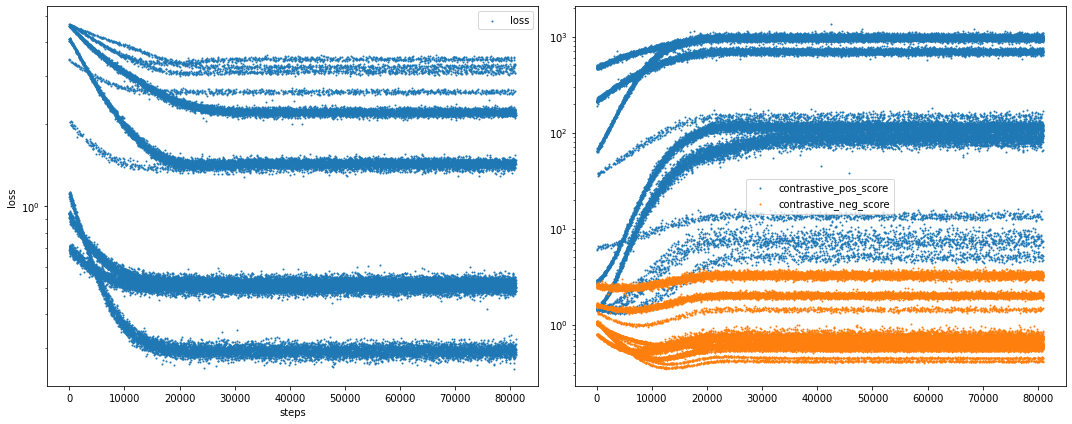

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.00  6.37  3.69 29.90 43.00 15.10 11.13 10.59  6.27  4.20  9.47  1.31  0.85  0.76      18.78      3.32
84    mrr    43.00  6.37  3.70 29.89 43.00 15.11 11.13 10.59  6.27  4.20  9.47  1.31  0.85  0.76      18.78      3.32
89    mrr    43.00  6.37  3.70 29.89 43.00 15.11 11.13 10.59  6.27  4.20  9.47  1.31  0.85  0.76      18.78      3.32
94    mrr    43.00  6.37  3.69 29.89 43.00 15.11 11.13 10.59  6.27  4.20  9.47  1.31  0.85  0.77      18.78      3.32
99    mrr    43.00  6.37  3.69 29.90 43.00 15.10 11.13 10.59  6.26  4.20  9.47  1.31  0.85  0.76      18.78      3.32
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [8]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-num_layers_0/output.log')

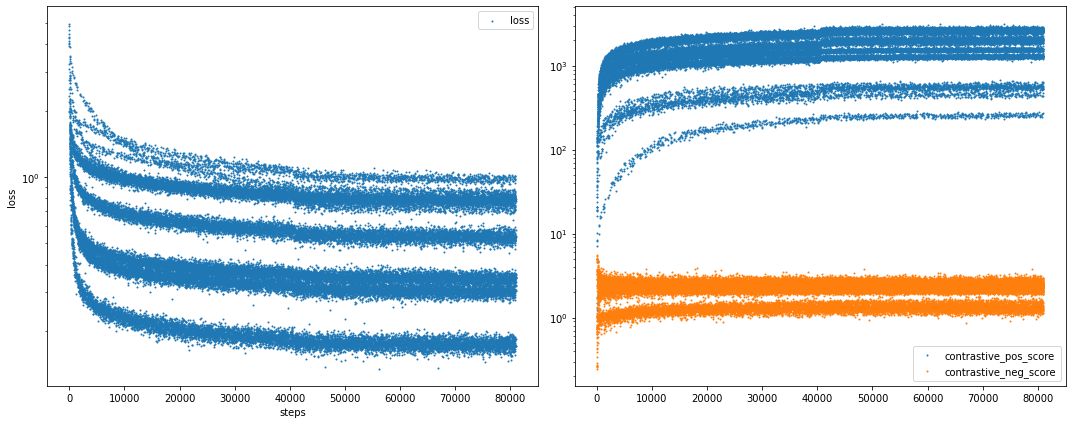

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.89 10.66  8.40 31.02 45.55 19.32 13.67 11.29  8.36  6.51  9.48  7.56  4.00  4.13      21.35      6.34
84    mrr    43.88 10.79  8.44 31.13 45.60 19.30 13.64 11.29  8.43  6.52  9.51  7.69  4.00  4.09      21.39      6.36
89    mrr    43.83 10.69  8.41 31.06 45.50 19.39 13.64 11.31  8.39  6.49  9.53  7.65  3.98  4.12      21.36      6.35
94    mrr    43.91 10.66  8.43 31.21 45.68 19.37 13.67 11.31  8.36  6.49  9.56  7.57  3.99  4.16      21.40      6.35
99    mrr    43.86 10.73  8.40 31.10 45.61 19.49 13.58 11.29  8.43  6.47  9.51  7.60  3.98  4.12      21.39      6.34
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [9]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-num_layers_1/output.log')

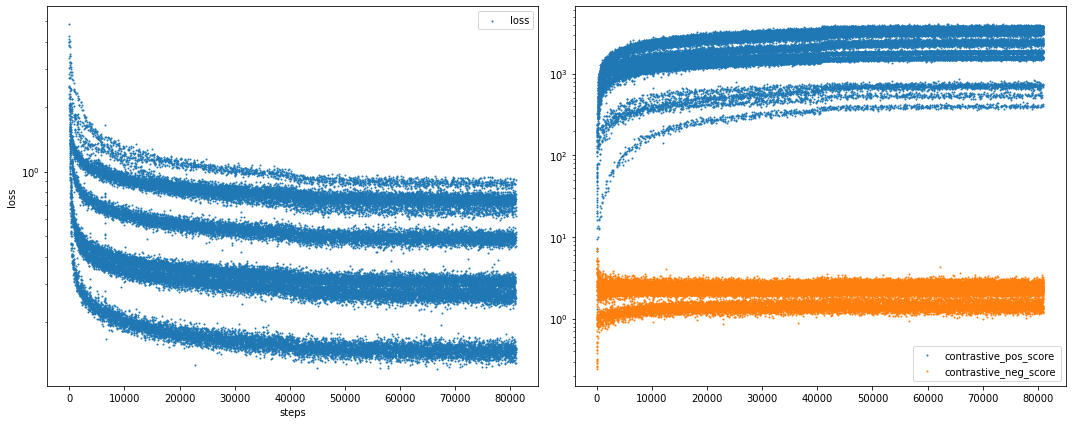

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.93 10.94  8.54 31.50 46.53 20.30 14.09 11.29  8.41  6.38  9.78  7.79  4.05  4.19      21.73      6.44
84    mrr    43.94 10.95  8.61 31.53 46.53 20.16 14.07 11.28  8.48  6.38  9.80  7.74  4.04  4.16      21.73      6.43
89    mrr    43.93 10.96  8.57 31.54 46.54 20.29 14.14 11.28  8.46  6.38  9.81  7.86  4.00  4.16      21.75      6.44
94    mrr    43.95 10.91  8.54 31.52 46.61 20.35 14.15 11.29  8.42  6.37  9.83  7.80  3.99  4.20      21.75      6.44
99    mrr    43.91 10.95  8.53 31.59 46.55 20.35 14.11 11.32  8.48  6.40  9.85  7.80  4.06  4.27      21.75      6.48
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [10]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-num_layers_1-hidden_8192/output.log')

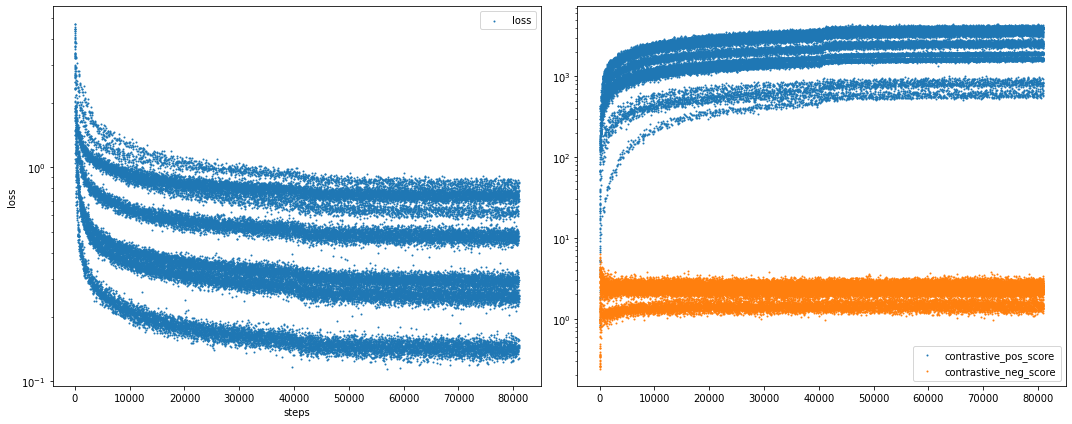

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.56 10.90  8.74 31.37 46.40 17.07 13.95 11.12  8.42  6.48  9.67  7.91  3.55  4.10      21.28      6.34
84    mrr    43.60 10.85  8.76 31.43 46.29 17.31 13.97 11.16  8.41  6.49  9.65  7.91  3.55  4.15      21.31      6.35
89    mrr    43.62 10.79  8.72 31.45 46.28 17.31 13.94 11.13  8.41  6.47  9.62  7.77  3.57  4.07      21.29      6.30
94    mrr    43.56 10.82  8.74 31.47 46.44 17.33 13.99 11.10  8.41  6.46  9.64  7.79  3.61  4.09      21.32      6.32
99    mrr    43.56 10.81  8.86 31.53 46.54 17.27 14.00 11.18  8.40  6.43  9.66  7.82  3.60  4.13      21.35      6.33
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [11]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-num_layers_2/output.log')

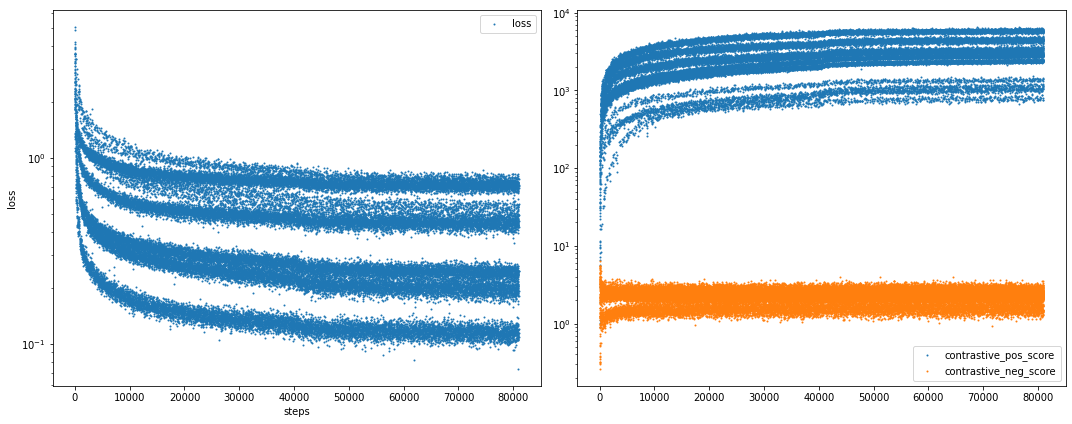

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    43.33 11.04  8.74 31.64 47.09 16.53 14.73 10.91  8.37  6.44  9.94  7.91  3.58  4.27      21.37      6.43
84    mrr    43.29 11.02  8.68 31.69 47.12 16.54 14.79 10.93  8.40  6.46 10.05  7.85  3.58  4.23      21.38      6.43
89    mrr    43.37 11.02  8.64 31.69 47.16 16.54 14.71 10.93  8.31  6.43  9.99  7.93  3.60  4.26      21.38      6.44
94    mrr    43.28 10.94  8.64 31.65 47.25 16.54 14.77 10.95  8.35  6.44 10.10  7.90  3.56  4.22      21.38      6.44
99    mrr    43.33 10.90  8.67 31.82 47.10 16.61 14.67 10.95  8.36  6.41 10.04  7.92  3.58  4.19      21.38      6.43
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [12]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-num_layers_2-hidden_8192/output.log')

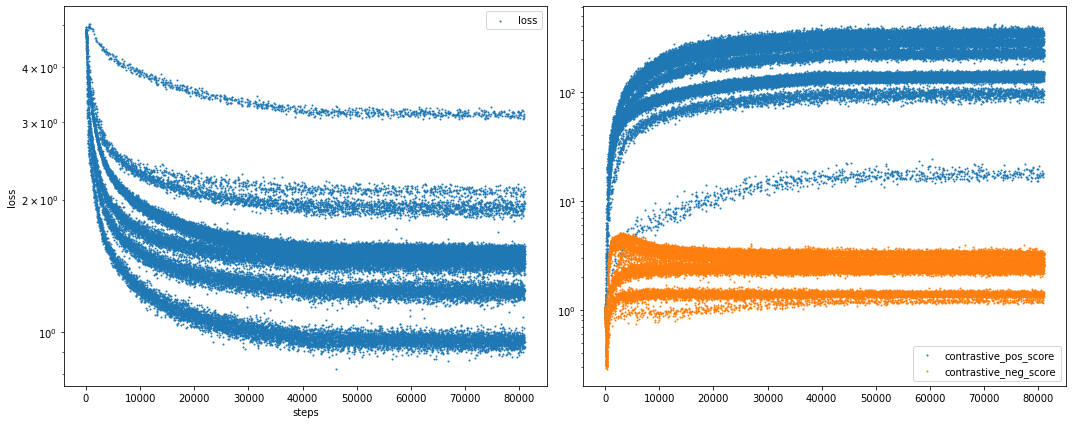

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    29.19  5.87  5.14  8.51  9.25  6.41  5.79  8.15  5.34  2.33  3.92  5.04  2.44  2.70       9.29      3.28
84    mrr    29.24  5.89  5.17  8.53  9.28  6.39  5.76  8.15  5.34  2.34  3.92  5.04  2.44  2.73       9.31      3.29
89    mrr    29.24  5.87  5.18  8.56  9.29  6.43  5.74  8.17  5.31  2.32  3.95  5.05  2.43  2.70       9.31      3.29
94    mrr    29.22  5.88  5.17  8.57  9.36  6.45  5.80  8.14  5.36  2.34  3.94  5.07  2.46  2.69       9.33      3.30
99    mrr    29.23  5.89  5.15  8.58  9.32  6.43  5.77  8.17  5.34  2.33  3.95  5.04  2.46  2.71       9.32      3.30
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [13]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-num_layers_4-hidden_64/output.log')

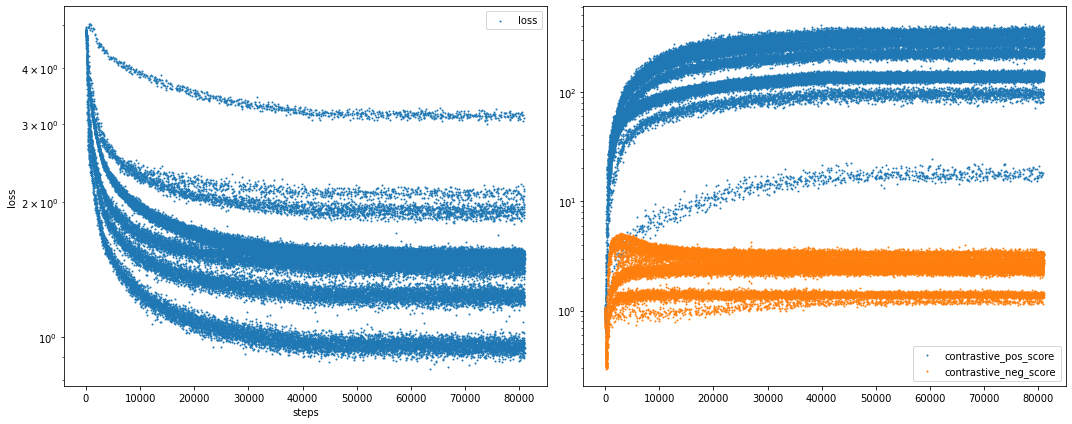

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    29.19  5.87  5.14  8.51  9.25  6.41  5.79  8.15  5.34  2.33  3.92  5.04  2.44  2.70       9.29      3.28
84    mrr    29.24  5.89  5.17  8.53  9.28  6.39  5.76  8.15  5.34  2.34  3.92  5.04  2.44  2.73       9.31      3.29
89    mrr    29.24  5.87  5.18  8.56  9.29  6.43  5.74  8.17  5.31  2.32  3.95  5.05  2.43  2.70       9.31      3.29
94    mrr    29.22  5.88  5.17  8.57  9.36  6.45  5.80  8.14  5.36  2.34  3.94  5.07  2.46  2.69       9.33      3.30
99    mrr    29.23  5.89  5.15  8.58  9.32  6.43  5.77  8.17  5.34  2.33  3.95  5.04  2.46  2.71       9.32      3.30
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [16]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-num_layers_4-hidden_64/output.log')

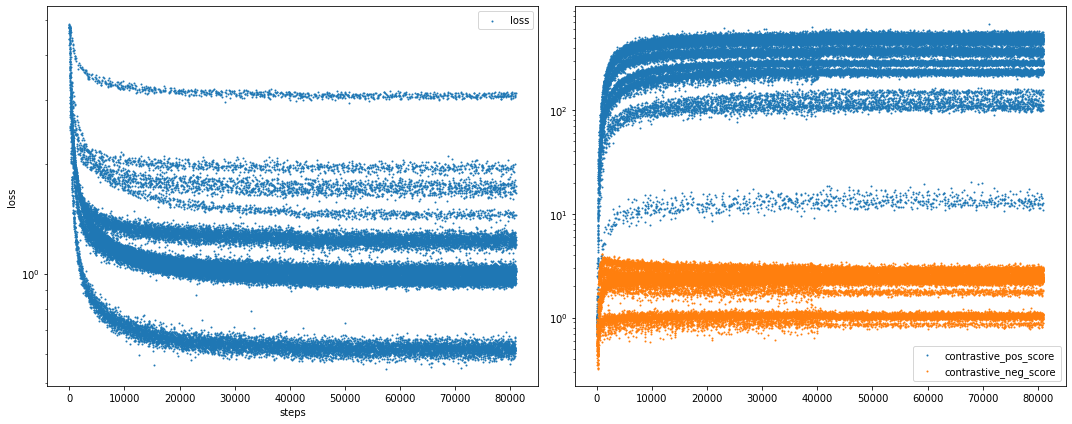

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    37.19  7.49  6.36 16.85 22.47 10.50  8.00 10.19  6.66  3.43  6.10  5.76  3.13  3.41      13.97      4.37
84    mrr    37.18  7.54  6.37 16.87 22.49 10.56  8.01 10.17  6.66  3.41  6.08  5.78  3.12  3.41      13.98      4.36
89    mrr    37.25  7.50  6.35 16.85 22.46 10.49  7.99 10.18  6.63  3.43  6.09  5.80  3.13  3.39      13.97      4.37
94    mrr    37.23  7.54  6.39 16.95 22.57 10.57  8.05 10.18  6.66  3.46  6.09  5.82  3.14  3.41      14.02      4.39
99    mrr    37.25  7.53  6.31 16.92 22.51 10.59  8.02 10.16  6.66  3.46  6.07  5.81  3.14  3.40      13.99      4.38
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [17]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-hidden_dim_128/output.log')

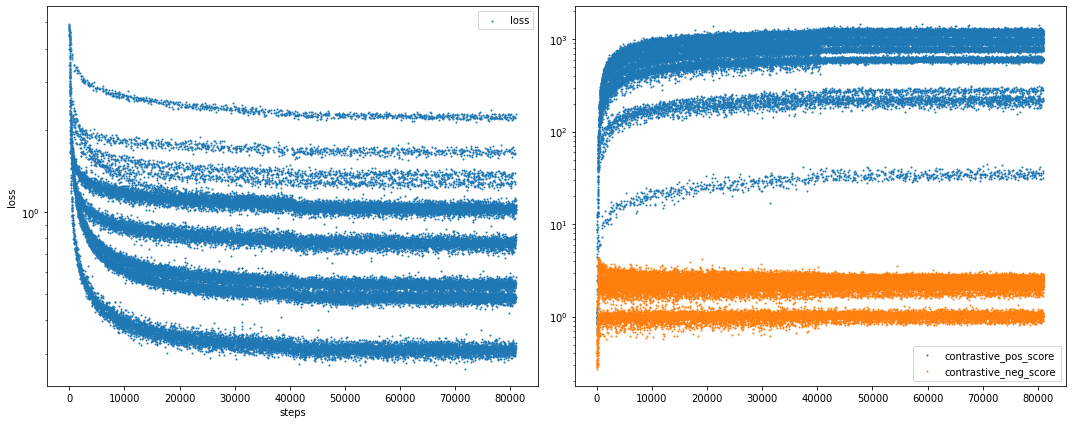

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    42.21  9.37  7.45 26.80 39.21 15.12 11.24 10.96  7.87  4.53  8.22  6.70  3.63  3.81      18.92      5.38
84    mrr    42.34  9.38  7.44 26.89 39.36 15.23 11.30 10.99  7.90  4.58  8.23  6.74  3.67  3.80      18.98      5.40
89    mrr    42.31  9.38  7.47 26.88 39.35 15.26 11.24 10.99  7.87  4.58  8.21  6.70  3.63  3.79      18.97      5.38
94    mrr    42.37  9.37  7.43 26.89 39.34 15.36 11.23 10.98  7.89  4.59  8.23  6.70  3.64  3.79      18.98      5.39
99    mrr    42.21  9.34  7.43 26.90 39.29 15.30 11.28 10.99  7.89  4.55  8.25  6.71  3.67  3.81      18.96      5.40
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [18]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-hidden_dim_512/output.log')

# without relational inference

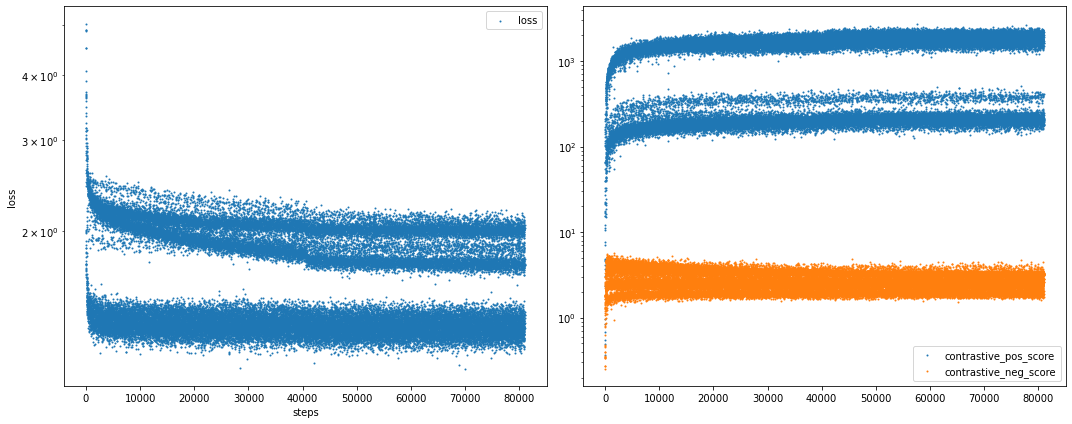

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    29.34  5.79  5.74  5.85  6.79  5.18  5.11  6.43  5.47  2.42  2.51  6.07  2.22  1.48       8.41      2.94
84    mrr    29.35  5.77  5.74  5.81  6.81  5.16  5.14  6.37  5.42  2.40  2.53  6.04  2.19  1.51       8.40      2.93
89    mrr    29.34  5.80  5.77  5.74  6.78  5.15  5.15  6.37  5.45  2.41  2.49  6.06  2.21  1.53       8.39      2.94
94    mrr    29.33  5.78  5.79  5.81  6.81  5.17  5.12  6.40  5.42  2.43  2.50  6.07  2.17  1.49       8.40      2.93
99    mrr    29.38  5.80  5.80  5.79  6.81  5.22  5.18  6.37  5.44  2.40  2.50  6.06  2.20  1.49       8.42      2.93
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [20]:
show_trajectory("log/FB15k-237/lmpnn-complex1k-without_relational_inference/output.log", metrics=['mrr'])

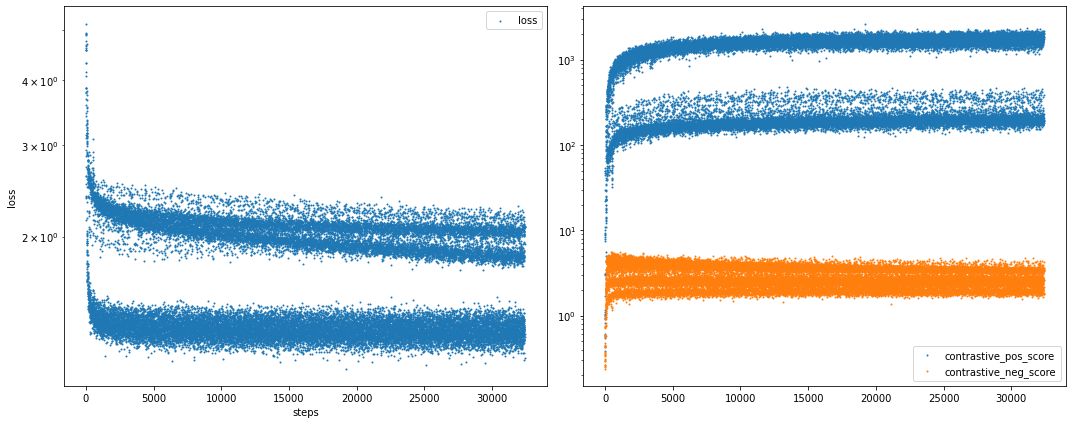

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
14    mrr    29.05  5.75  5.80  5.92  6.51  5.21  5.20  6.33  5.33  2.31  2.36  5.99  2.19  1.51       8.34      2.87
19    mrr    28.92  5.68  5.70  5.94  6.43  5.13  5.03  6.23  5.28  2.36  2.41  5.94  2.14  1.45       8.26      2.86
24    mrr    29.09  5.76  5.71  5.91  6.61  5.30  5.14  6.35  5.35  2.41  2.38  6.06  2.17  1.50       8.36      2.90
29    mrr    29.11  5.77  5.68  5.96  6.61  5.23  5.12  6.52  5.39  2.40  2.45  5.99  2.20  1.53       8.38      2.91
34    mrr    29.24  5.80  5.92  5.78  6.63  5.24  5.27  6.26  5.54  2.34  2.39  6.09  2.23  1.55       8.41      2.92
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [24]:
show_trajectory("log/FB15k-237/lmpnn-complex1k-mlp_relational_hash/output.log", metrics=['mrr'])

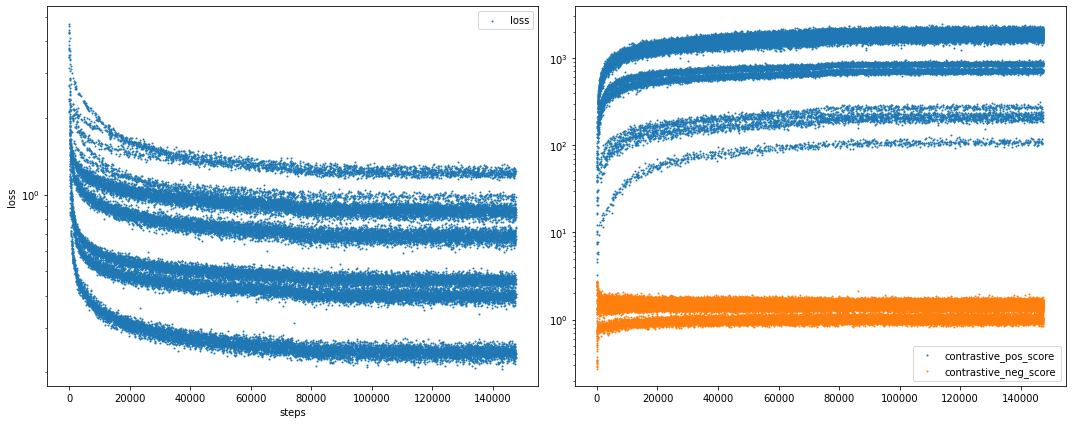

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    71.03 21.93 17.06 48.82 63.46 31.22 26.90 23.58 18.45 14.72 13.27 10.72  6.58 10.30      35.83     11.12
84    mrr    70.97 21.90 17.07 48.76 63.40 31.16 26.87 23.60 18.49 14.68 13.25 10.71  6.58 10.28      35.80     11.10
89    mrr    71.02 21.89 17.12 48.82 63.51 31.31 26.86 23.63 18.50 14.72 13.31 10.69  6.64 10.27      35.85     11.12
94    mrr    71.02 21.93 17.10 48.82 63.54 31.27 26.90 23.65 18.50 14.65 13.21 10.74  6.62 10.33      35.86     11.11
99    mrr    71.00 21.90 17.06 48.77 63.43 31.29 26.87 23.64 18.43 14.66 13.24 10.70  6.60 10.33      35.82     11.10
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [15]:
show_trajectory("log/FB15k/lmpnn-complex1k-default/output.log", metrics=['mrr'])

In [39]:
show_trajectory("log/FB15k/lmpnn-complex1k-temp_0.01/output.log", metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    74.70 22.52 17.64 54.46 68.16 28.69 24.70 25.14 19.90 16.32 15.97 10.09  8.11 11.70      37.32     12.44
84    mrr    74.89 22.57 17.68 54.35 68.32 28.96 24.78 25.02 20.06 16.33 15.88 10.16  8.04 11.79      37.40     12.44
89    mrr    74.95 22.58 17.74 54.55 68.43 29.17 24.71 25.13 20.00 16.28 16.01 10.20  8.08 11.82      37.47     12.48
94    mrr    74.99 22.60 17.73 54.63 68.35 29.11 24.60 25.16 20.03 16.38 15.88 10.16  8.09 11.78      37.47     12.46
99    mrr    75.05 22.57 17.75 54.66 68.34 29.19 24.83 25.14 20.01 16.46 15.88 10.32  8.23 11.76      37.50     12.53
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [40]:
print("***"*10)
show_trajectory("log/FB15k/lmpnn-complex1k-temp_0.05/output.log", metrics=['mrr'])

******************************
CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    75.85 24.57 18.96 53.24 68.37 34.07 28.54 25.45 20.04 17.15 15.86 11.65  7.57 11.12      38.79     12.67
84    mrr    75.89 24.62 18.88 53.27 68.43 34.27 28.65 25.52 20.08 17.16 15.88 11.65  7.64 11.16      38.85     12.70
89    mrr    75.95 24.64 18.99 53.38 68.55 34.19 28.65 25.54 20.05 17.13 15.93 11.71  7.64 11.16      38.88     12.71
94    mrr    75.94 24.64 18.99 53.31 68.54 34.26 28.69 25.46 20.07 17.13 15.95 11.66  7.61 11.06      38.88     12.68
99    mrr    75.98 24.62 18.97 53.37 68.61 34.23 28.69 25.48 20.10 17.12 15.91 11.69  7.58 11.10      38.89     12.68
NN evaluate test
                1p    2p    3p    2i

In [41]:
show_trajectory("log/FB15k/lmpnn-complex1k-temp_0.05-hidden_dim_8192/output.log", metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
19    mrr    74.31 22.75 17.59 51.69 66.57 28.59 26.50 25.09 19.36 17.14 15.15 10.90  6.85 10.59      36.94     12.13
24    mrr    74.64 23.11 17.75 52.05 66.67 29.21 27.10 25.08 19.85 16.97 15.29 11.04  6.99 10.87      37.27     12.23
89    mrr    76.32 25.96 19.96 54.07 69.06 36.12 30.24 25.80 20.83 17.74 16.57 12.40  7.94 11.43      39.82     13.22
94    mrr    76.34 26.03 19.97 53.98 69.03 36.13 30.28 25.86 20.85 17.71 16.58 12.34  7.93 11.44      39.83     13.20
99    mrr    76.40 26.09 19.99 54.07 69.21 36.43 30.31 25.84 20.92 17.74 16.57 12.38  7.97 11.45      39.92     13.22
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [42]:
show_trajectory("log/FB15k/lmpnn-complex1k-temp_0.2/output.log", metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    67.64 19.94 15.68 46.47 60.85 28.32 25.63 22.14 17.30 12.71 11.78  9.32  5.72  9.06      33.77      9.72
84    mrr    67.63 19.91 15.73 46.45 60.77 28.33 25.64 22.10 17.28 12.70 11.74  9.28  5.75  9.10      33.76      9.72
89    mrr    67.62 19.88 15.69 46.40 60.79 28.26 25.61 22.06 17.27 12.68 11.76  9.25  5.76  9.12      33.73      9.71
94    mrr    67.60 19.86 15.71 46.45 60.87 28.28 25.63 22.05 17.28 12.63 11.78  9.27  5.73  9.10      33.75      9.70
99    mrr    67.59 19.85 15.64 46.44 60.85 28.27 25.63 22.07 17.28 12.67 11.74  9.26  5.72  9.12      33.74      9.70
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [43]:
show_trajectory("log/nell/lmpgnn-complex1k-temp_0.2/output.log", metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    58.03 18.94 16.33 37.03 50.59 25.33 23.76 15.47 12.92  7.48 10.56 11.59  3.92  4.43      28.71      7.60
84    mrr    58.00 18.93 16.39 37.00 50.65 25.42 23.81 15.52 12.96  7.45 10.58 11.56  3.91  4.47      28.74      7.59
89    mrr    58.02 19.05 16.43 37.06 50.72 25.43 23.77 15.47 12.90  7.54 10.53 11.63  3.91  4.46      28.76      7.62
94    mrr    58.02 19.01 16.35 36.99 50.63 25.43 23.91 15.46 12.96  7.47 10.53 11.52  3.85  4.38      28.75      7.55
99    mrr    58.01 19.05 16.39 37.06 50.81 25.53 23.85 15.51 12.94  7.48 10.54 11.59  3.90  4.44      28.79      7.59
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

In [44]:
print("*"*30)
show_trajectory("log/nell/lmpgnn-complex1k-default/output.log", metrics=['mrr'])

******************************
CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    58.51 20.02 17.36 37.72 52.65 26.29 24.36 15.78 13.27  7.96 11.01 12.91  4.08  4.57      29.55      8.10
84    mrr    58.50 20.08 17.47 37.74 52.80 26.38 24.44 15.82 13.31  7.99 11.07 13.01  4.08  4.56      29.62      8.14
89    mrr    58.54 20.09 17.57 37.76 52.73 26.28 24.48 15.80 13.37  7.98 10.95 13.00  4.05  4.62      29.63      8.12
94    mrr    58.49 20.09 17.47 37.85 52.81 26.46 24.55 15.83 13.40  7.97 11.08 12.91  4.06  4.58      29.66      8.12
99    mrr    58.51 20.04 17.34 37.80 52.89 26.40 24.36 15.79 13.32  7.97 11.03 13.07  4.07  4.53      29.60      8.14
NN evaluate test
                1p    2p    3p    2i

In [45]:
print("*"*30)
show_trajectory("log/nell/lmpgnn-complex1k-hidden_dim-8192/output.log", metrics=['mrr'])

******************************
CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    58.48 20.29 17.58 38.08 53.72 27.22 25.16 15.83 13.33  7.79 10.82 13.02  4.05  4.45      29.97      8.03
84    mrr    58.44 20.42 17.66 38.15 54.02 27.35 25.20 15.83 13.30  7.81 10.88 12.97  4.05  4.49      30.04      8.04
89    mrr    58.50 20.38 17.75 38.05 53.65 27.29 25.12 15.80 13.30  7.78 10.81 13.06  4.04  4.44      29.98      8.02
94    mrr    58.52 20.32 17.76 38.23 53.81 27.44 25.15 15.81 13.30  7.79 10.88 12.94  4.01  4.46      30.04      8.01
99    mrr    58.43 20.31 17.71 38.31 53.91 27.40 25.22 15.79 13.34  7.75 10.91 13.01  4.08  4.53      30.05      8.06
NN evaluate test
                1p    2p    3p    2i

In [46]:
show_trajectory("log/nell/lmpgnn-complex1k-temp_0.05/output.log", metrics=['mrr'])

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
79    mrr    57.54 19.77 16.96 37.42 53.45 23.77 23.60 15.18 13.31  7.81 11.72 12.68  4.21  4.76      29.00      8.23
84    mrr    57.75 19.74 17.09 37.61 53.79 24.15 23.72 15.23 13.36  7.73 11.68 12.77  4.22  4.68      29.16      8.22
89    mrr    57.65 19.84 17.22 37.62 53.86 23.87 23.58 15.15 13.22  7.80 11.75 12.75  4.18  4.73      29.11      8.24
94    mrr    57.53 19.73 17.36 37.83 54.01 24.17 23.81 15.06 13.16  7.81 11.89 12.94  4.18  4.72      29.18      8.31
99    mrr    57.64 19.84 17.25 37.62 54.07 24.12 23.65 15.14 13.17  7.69 11.76 12.85  4.25  4.78      29.17      8.27
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up 

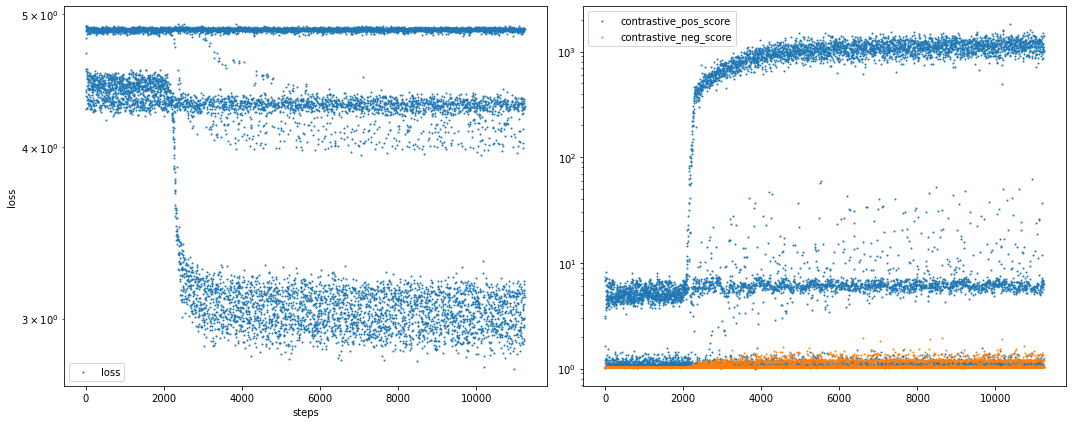

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr     4.78  3.49  2.96  0.17  0.09  2.92  3.29  0.08  2.46  0.10  0.08  3.78  1.42  0.50       2.25      1.18
9     mrr     4.79  3.51  3.02  0.17  0.09  2.89  3.42  0.08  2.57  0.10  0.08  3.75  1.40  1.00       2.28      1.26
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr     4.97  3.55  3.27  0.15  0.11  3.30  3.55  0.18  2.77  0.15  0.12  3.20  1.41  0.62       2.43      1.10
9     mrr     4.98  3.67  3.29  0.14  0.10  3.40  3.81  0.17  3.00 

In [12]:
show_trajectory("log/fb15k-237/pretrain_complex1000-train_kge/output.log", metrics=['mrr'])